### Import libraries and create DataFrame from csv 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))
weeks = str(start_week) if start_week == end_week else f"{start_week} - {end_week}"

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_data(start_week, end_week):
    data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("RB_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if data.empty:
            data = temp_df
        else:
            data = data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                data[base_column] = data[column]
            elif base_column in ['LG']:  # Take the maximum value
                data[base_column] = data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                data[base_column] += data[column]
            data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    data['Y/A'] = (data['YDS'] / data['ATT']).round(1)
    data['Y/R'] = (data['YDS.1'] / data['REC']).round(1)
    data['FPTS/G'] = (data['FPTS'] / data['G']).round(1)

    return data

# Load and aggregate data for the selected weeks
df = read_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df = df.sort_values(by='Rank')
df.head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,G,FPTS,FPTS/G,Weeks
5,1,Austin Ekeler (LAC),48,143,3.0,20,1,3,13,22,165,12.7,1,3,65.8,21.9,8 - 10
9,2,Rachaad White (TB),49,163,3.3,16,0,2,13,14,163,12.5,1,3,63.6,21.2,8 - 10
3,3,Alvin Kamara (NO),35,127,3.6,16,0,1,15,17,128,8.5,1,3,56.5,18.8,8 - 10
2,4,Gus Edwards (BAL),35,156,4.5,42,3,6,3,3,18,6.0,0,3,56.4,18.8,8 - 10
0,5,Jahmyr Gibbs (DET),40,229,5.7,35,4,3,8,10,72,9.0,0,2,56.1,28.0,8 - 10
10,6,Josh Jacobs (LV),68,275,4.0,40,3,3,4,6,38,9.5,0,3,51.3,17.1,8 - 10
7,7,Joe Mixon (CIN),41,170,4.1,20,1,3,10,12,53,5.3,0,3,50.3,16.8,8 - 10
1,8,Christian McCaffrey (SF),28,149,5.3,19,0,1,12,17,111,9.2,1,2,50.0,25.0,8 - 10
24,9,Brian Robinson Jr. (WAS),36,160,4.4,29,1,1,9,10,143,15.9,1,3,49.3,16.4,8 - 10
21,10,Najee Harris (PIT),39,164,4.2,25,2,2,10,13,63,6.3,0,3,44.7,14.9,8 - 10


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [51]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/A', 'LG', 'Y/R', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
5,1,Austin Ekeler (LAC),3.0,20,12.7,3,65.8,21.9,8 - 10,16.0,47.7,0.3,1.0,4.3,7.3,55.0,0.3
9,2,Rachaad White (TB),3.3,16,12.5,3,63.6,21.2,8 - 10,16.3,54.3,0.0,0.7,4.3,4.7,54.3,0.3
3,3,Alvin Kamara (NO),3.6,16,8.5,3,56.5,18.8,8 - 10,11.7,42.3,0.0,0.3,5.0,5.7,42.7,0.3
2,4,Gus Edwards (BAL),4.5,42,6.0,3,56.4,18.8,8 - 10,11.7,52.0,1.0,2.0,1.0,1.0,6.0,0.0
0,5,Jahmyr Gibbs (DET),5.7,35,9.0,2,56.1,28.0,8 - 10,20.0,114.5,2.0,1.5,4.0,5.0,36.0,0.0
10,6,Josh Jacobs (LV),4.0,40,9.5,3,51.3,17.1,8 - 10,22.7,91.7,1.0,1.0,1.3,2.0,12.7,0.0
7,7,Joe Mixon (CIN),4.1,20,5.3,3,50.3,16.8,8 - 10,13.7,56.7,0.3,1.0,3.3,4.0,17.7,0.0
1,8,Christian McCaffrey (SF),5.3,19,9.2,2,50.0,25.0,8 - 10,14.0,74.5,0.0,0.5,6.0,8.5,55.5,0.5
24,9,Brian Robinson Jr. (WAS),4.4,29,15.9,3,49.3,16.4,8 - 10,12.0,53.3,0.3,0.3,3.0,3.3,47.7,0.3
21,10,Najee Harris (PIT),4.2,25,6.3,3,44.7,14.9,8 - 10,13.0,54.7,0.7,0.7,3.3,4.3,21.0,0.0


### Calculate the correlations for the final stats across different conditions

In [52]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/A,0.38,0.36,0.20,0.09,0.26
LG,0.68,0.61,0.28,0.02,0.40
Y/R,0.32,0.31,0.31,0.07,0.25
ATT/game,0.84,0.80,0.58,0.25,0.62
YDS/game,0.86,0.83,0.66,0.39,0.69
20+/game,0.47,0.45,0.31,0.13,0.34
TD/game,0.69,0.69,0.58,0.47,0.61
REC/game,0.75,0.70,0.52,0.51,0.62
TGT/game,0.77,0.72,0.53,0.46,0.62
YDS.1/game,0.75,0.71,0.62,0.58,0.66


### Assign the weights for the final stats

In [53]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/A,0.26,0.07,1
LG,0.40,0.16,1
Y/R,0.25,0.06,1
ATT/game,0.62,0.38,1
YDS/game,0.69,0.47,1
20+/game,0.34,0.12,1
TD/game,0.61,0.37,1
REC/game,0.62,0.38,1
TGT/game,0.62,0.38,1
YDS.1/game,0.66,0.44,1


### Multiply the assigned weights to the final stats

In [54]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df_weight = df[['Rank', 'Player', 'FPTS/G'] + weight_columns]
df_weight.sort_values(by=['FPTS/G'],ascending=False).head(10)

,Rank,Player,FPTS/G,Y/A_weighted,LG_weighted,Y/R_weighted,ATT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,REC/game_weighted,TGT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
0,5,Jahmyr Gibbs (DET),28.0,5.7,35,9.0,20.0,114.5,2.0,1.5,4.0,5.0,36.0,0.0
1,8,Christian McCaffrey (SF),25.0,5.3,19,9.2,14.0,74.5,0.0,0.5,6.0,8.5,55.5,0.5
5,1,Austin Ekeler (LAC),21.9,3.0,20,12.7,16.0,47.7,0.3,1.0,4.3,7.3,55.0,0.3
9,2,Rachaad White (TB),21.2,3.3,16,12.5,16.3,54.3,0.0,0.7,4.3,4.7,54.3,0.3
8,15,Javonte Williams (DEN),19.9,3.4,15,6.3,24.0,82.0,0.0,0.0,3.5,3.5,22.0,1.0
3,3,Alvin Kamara (NO),18.8,3.6,16,8.5,11.7,42.3,0.0,0.3,5.0,5.7,42.7,0.3
2,4,Gus Edwards (BAL),18.8,4.5,42,6.0,11.7,52.0,1.0,2.0,1.0,1.0,6.0,0.0
94,41,David Montgomery (DET),17.6,9.7,75,NaN,12.0,116.0,4.0,1.0,0.0,0.0,0.0,0.0
10,6,Josh Jacobs (LV),17.1,4.0,40,9.5,22.7,91.7,1.0,1.0,1.3,2.0,12.7,0.0
137,21,Keaton Mitchell (BAL),17.0,14.3,60,14.0,6.0,86.0,4.5,1.0,1.0,1.5,14.0,0.0


### Display the columns potentially to be included in the average weighted score

In [55]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['FPTS/G']

### Define the columns to be used for the average weighted score

In [56]:
# Define select columns to be used for the average weighted score
avg = ['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [57]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [58]:
# Display the results for the select columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance'] + final_columns]
analysis.set_index('Rank', inplace=True)
analysis = analysis.sort_values(by='Final Rank', ascending=True)
analysis.to_excel("RB_Analysis.xlsx", index=False)
analysis.head(30)

,Final Rank,Player,Score,Variance,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Rank,,,,,,,,,,,,,,,,,,,
5,1,Jahmyr Gibbs (DET),29.9,4,5.7,35,9.0,2,56.1,28.0,8 - 10,20.0,114.5,2.0,1.5,4.0,5.0,36.0,0.0
8,2,Christian McCaffrey (SF),26.3,6,5.3,19,9.2,2,50.0,25.0,8 - 10,14.0,74.5,0.0,0.5,6.0,8.5,55.5,0.5
2,3,Rachaad White (TB),22.3,-1,3.3,16,12.5,3,63.6,21.2,8 - 10,16.3,54.3,0.0,0.7,4.3,4.7,54.3,0.3
15,4,Javonte Williams (DEN),22.1,11,3.4,15,6.3,2,39.8,19.9,8 - 10,24.0,82.0,0.0,0.0,3.5,3.5,22.0,1.0
1,5,Austin Ekeler (LAC),21.9,-4,3.0,20,12.7,3,65.8,21.9,8 - 10,16.0,47.7,0.3,1.0,4.3,7.3,55.0,0.3
6,6,Josh Jacobs (LV),21.2,0,4.0,40,9.5,3,51.3,17.1,8 - 10,22.7,91.7,1.0,1.0,1.3,2.0,12.7,0.0
41,7,David Montgomery (DET),20.9,34,9.7,75,NaN,1,17.6,17.6,8 - 10,12.0,116.0,4.0,1.0,0.0,0.0,0.0,0.0
18,8,Saquon Barkley (NYG),20.2,10,4.4,34,2.6,3,37.2,12.4,8 - 10,21.7,94.7,1.3,0.0,2.3,4.0,6.0,0.0
24,9,Travis Etienne Jr. (JAC),19.5,15,3.5,16,15.8,2,32.3,16.2,8 - 10,16.5,57.0,0.0,0.0,2.5,5.0,39.5,0.5


### Compare per-game stats of two players and visualize the results

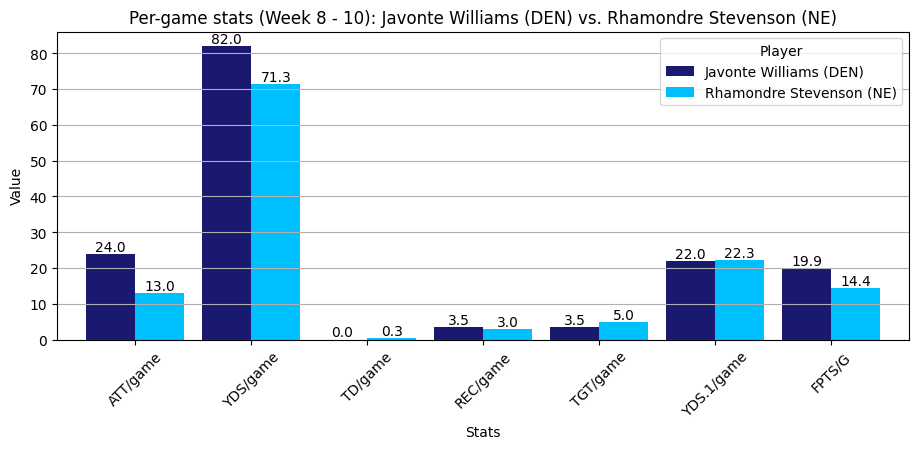

,Final Rank,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Player,,,,,,,,,,,,,,,,
Javonte Williams (DEN),4,3.4,15,6.3,2,39.8,19.9,8 - 10,24.0,82.0,0.0,0.0,3.5,3.5,22.0,1.0
Rhamondre Stevenson (NE),11,5.5,64,7.4,3,43.1,14.4,8 - 10,13.0,71.3,1.3,0.3,3.0,5.0,22.3,0.0


In [59]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats (Week {weeks}): {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]